## Changelog
### URL [github UMAP fork](https://github.com/kruus/umap)
use branch **constraints**

### pin_mask demo
- We get a $1^{st}$ embedding (using random init)
- linearly transform so "good" and "bad" samples so their x values end up at [-1,+1]
    - (in least-squares sense)
- then re-embed "pinning" those x values *exactly* at -1, +1
    - (could random-init by-hand, then fix x values for single pin_mask umap fit)
- umap applies no gradient (but does apply rescaling)
- we determine the new linear rescaling
- and remap the embedding back to good|bad x-values -1|+1

### New
- We select a good/bad entry based on feature 0 "sepal length"
  for each iris species.  Lowest pinned to x=-1, highest pinned to x=+1
  
  
- still perhaps better to ROTATE (see Kabsch algorithm) the initial embedding
  such that good|bad points are aligned *towards* (-1,0)|(+1,0) idealized drag
  positions
   - then rescale and shift to put their x-centroids exactly at (-1,0)|(+1,0)
- Now we rotate, scale & shift
- TODO: option to **shear** instead of orthogonally rotate

#### behavior is not (completely) *as expected*!
- Still no *constraint* of having unpinned points having x-values between (-1,+1)

### drag-n-drop & high-D embedding
The current approach embeds high-D euclidean to low-D euclidean.  However, the drag'n'drop *user interest* was generated from a single high-D feature.

#### What rotation of high-D space, when projected onto the first 2 dims, best matches the dragged points?
- i.e. align 1st PCA component of the dragged point data with x axis.
   - 2nd one would be some randomish projection (ok, user doesn't really care about *y* yet,
     except that it should yield "some" separation in lo-D space
- a weighted-Euclidean metric (in the rotated hi-D space) might work nicely.
- but no dims should get *zero* weight
   - to avoid catastropic info loss
   - so 'y' axis still allows separation of individual items
   - (do not want all items to appear on single left-right line

### NEW: UMAP-constraints
- added a 'TRIAL' code blocks into layouts.py to test dimension-wise clipping bound
- clipping bounds for *x* must be -10,+10 so that spectral init is not fubar.
- *GOOD*: final embedding now does have *unpinned points* "on the inside"

### NEW: add hover tool to inspect bokeh embedding (and data) values

### NEW: show user-points adding a new dimension.
Here a new user x-axis supplements the original embedding, which is now in yz-plane.
Pinned points are at x=+/-10, while all others are initialized at x=0.
UMAP is run to generate a 3-D embedding, pulling "neighbors" away from the x=0 plane
The yz-axes of the 3-D UMAP embedding can then be reprojected back into 2-D, such that
the x-axis still reflects good/bad user info.

### NEW: add a user-passible `constraint` object (default=None) to UMAP.
- or actually, a list of constraint objects
- `constraint.project_onto_constraint( low_embedding_vector )` may do an
  in-place modification of `low_embedding_vector`
- layouts.py has a `jitclass` called `DimLohi` example of a clipping constraint
- other constraint types might project the full data set (during/post-epoch?),
  perhaps like `DimLoHi:project_rows_onto_constraint(self, mat)`

### MEW: UMAP-constraints supports user-defined constraints
Original UMAP fork supported only a 'pin_mask' array argument.
Now general constraints are numba JIT functions passed into:

- the UMAP constructor (for dataset-independent constraints on points/gradients)
- or the UMAP fitting routine (for dataset-dependent constrains, like pinning certain
  points
  
These user constraint function get applied at appropriate times during the
gradient descent phase of UMAP to beef up the usual UMAP "forces" that adjust
positions of the lo-D embedded points.
  
### *LATER*: see if UMAP can crudely be simulated by spring & dashpot physics
- *springs* : equilibrium distances and force constants
- *dashpots* : motion damping proportional to velocity

Why? such force fields can be quickly done client side, all in the low-dim embedding space.

Init via nearest-neighbors + random sample of distant neighbors
Fine-tuning might double-check points with "too-large" force-gradient
and add some small number of careful long-distance springs that best reduce this.

- Approximating force-field would be generated server-side.
- Client drag-n-drop uses approx force field (perhaps with some expanded *user dims*)
- State is preserved after rerunning umap? Or is it better to save the spring model
  and let the user decide when to run a full UMAP recalc (with new drag constraints etc.)

Shorter distance ~ higher spring constant; longer ~ weak spring constants



In [1]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import CategoricalColorMapper, ColumnDataSource, HoverTool
from bokeh.palettes import Category10, Colorblind, Viridis, Viridis256
from bokeh.transform import linear_cmap
from bokeh.io import output_notebook, export_png
from bokeh.layouts import column, gridplot
output_notebook()

import umap
import numpy as np
from sklearn.datasets import load_iris
import pandas as pd

# Note: bokeh export_png requires 'conda install selenium'

Loading BokehJS ...

In [2]:
import umap
# from earlier 'jitclass' version
#umap.constraints.test_HardPinIndexed()
#umap.constraints.test_SoftPinIndexed()
#umap.constraints.test_DimLohi()
# dumb numba function api
umap.constraints.test_dimlohi()



test dimlohi OK


In [3]:
iris = load_iris()

In [4]:
print(type(iris))
print(type(iris.data))
print(iris.data.shape, iris.data[0:5,])
print(iris.target.shape, iris.target[0:5])
print(iris.target_names.size, iris.target_names)
print(len(iris.feature_names), iris.feature_names)

<class 'sklearn.utils.Bunch'>
<class 'numpy.ndarray'>
(150, 4) [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
(150,) [0 0 0 0 0]
3 ['setosa' 'versicolor' 'virginica']
4 ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [5]:
# I'm interested in feature 0 (sepal length) really small.
feature_of_interest = 0
fi_name = iris.feature_names[feature_of_interest]
di = data_of_interest = iris.data[:,feature_of_interest]
if True:
    # This time, choose good/bad from each iris species
    nFeat = iris.target_names.size
    good10 = np.zeros(nFeat,dtype=np.int32)
    bad10 = np.zeros(nFeat,dtype=np.int32)
    for t,name in enumerate(iris.target_names):
        print(t,name)
        mask = (iris.target==t)
        #print(di[mask])
        dilo = np.argmin(di[mask]) # index within masked group
        dihi = np.argmax(di[mask])
        #print(dilo)
        diilo = np.arange(di.shape[0]) [mask] [dilo] # index within original
        diihi = np.arange(di.shape[0]) [mask] [dihi]
        #print(diilo)
        good10[t] = diilo
        bad10[t] = diihi

    print("\nSelected shortest (good) and longest (bad)",
          fi_name, "of each iris species")
    print(fi_name, "good/bad values:")
    row_names = ["good", "bad"]
    col_names = iris.target_names
    matrix = np.zeros((2,3))
    for t,name in enumerate(col_names):
        matrix[0,t] = iris.data[ good10[t], feature_of_interest ]
        matrix[1,t] = iris.data[ bad10[t], feature_of_interest ]
    df = pd.DataFrame(matrix, columns=col_names, index=row_names)
    print(df)
    print("\n")
    

if False: # older case
    # choose 2 "interesting" examples and 2 uninteresting
    nFeat = 4
    print("feature_of_interest",feature_of_interest)
    best = np.argmin(data_of_interest)
    #good3 = np.argpartition(iris.data[:,0], 3)
    #print("good",good, "good3",good3)
    #print(iris.data[good3,])
    goods = np.argsort(data_of_interest)
    good10 = goods[0:nFeat]
    bad10 = goods[-nFeat:,]

print("good10",good10,"\ndata of goods:\n",iris.data[good10,])
print("bad10",bad10,  "\ndata of bads:\n",iris.data[bad10])
#

0 setosa
1 versicolor
2 virginica

Selected shortest (good) and longest (bad) sepal length (cm) of each iris species
sepal length (cm) good/bad values:
      setosa  versicolor  virginica
good     4.3         4.9        4.9
bad      5.8         7.0        7.9


good10 [ 13  57 106] 
data of goods:
 [[4.3 3.  1.1 0.1]
 [4.9 2.4 3.3 1. ]
 [4.9 2.5 4.5 1.7]]
bad10 [ 14  50 131] 
data of bads:
 [[5.8 4.  1.2 0.2]
 [7.  3.2 4.7 1.4]
 [7.9 3.8 6.4 2. ]]


### UMAP (no constraints yet)
- This demo is *atypical* in that the original data has *few* (4) dimensions
    - It is mostly to demo and test the invasive changes to UMAP-constrain
    - For images or text, hi-D embedding may have 32 to thousands or more dimensions.
- UMAP (t-SNE, pyMDE) *conceptually* matches a hi-D weighted graph to a counterpart in lo-D
    - n.n. in hi-D should remain n.n. in lo-D, ...

- In hi-D, *local intrinsic dimension* typically remains low, even as dimensionality increases.
- So you can imagine *real data* populating "ribbons" in hi-D space
  - i.e. if \# of points in a ball of radius r scales as $r^{N-1}$ around some point,
    real data roughly lies on an N-dimensional ribbon.
    (Often N is in 8-16 range, but sometimes up to 40)
  - Picture the hi-D space filled with such "ribbons" of probability density.
  - Often you can see UMAP/tSNE mapping these ribbons onto line-like features
    when visualized in 2-D plots

### Can UMAP do an identity map?
The next cell shows that if there is no dimension reduction,
even with enough points constrained not to move,
UMAP still does adjust some points by a large distance.

I am not recovering an identity map.  I guess the question is
whether the shape "behaves significantly differently" !

I suppose that UMAP is "spreading out" the unconstrained points (since it can).
Even with densmap, the UMAP is not doing an identity mapping.

In [6]:
# experimental ... no dimension reduction
print(iris.data.shape)
##%%writefile iris4-emb-init.log
##%%capture iris4-emb-init.log
init0 = iris.data.copy().astype(np.float32)
print(init0[0])
print(init0[10:15])
fix0 = np.ones((iris.data.shape[0]), dtype=np.int32)
fix0[good10] = 0.0
fix0[bad10] = 0.0
fix0[100] = 0.0
fix0[120] = 0.0
fix0[130] = 0.0
fix0[0] = fix0[1] = 0.0
print("fix0.shape",fix0.ndim, fix0.shape, fix0.shape[0], " init0.shape",init0.shape)
print(fix0[10:15])

#init_random_state = None  # this allows parallel umap lo-D embedding optimization
init_random_state = 12345 # this will force single-threaded (more reproducible)

emb0 = umap.UMAP( min_dist=0.001,
    n_neighbors=30, learning_rate=1e-2, random_state=init_random_state,
    init = init0, #densmap=True,
    n_components = iris.data.shape[1],
).fit_transform(iris.data, data_constrain = fix0)
print(iris.data[0], emb0[0])
print(init0[good10], "\n", emb0[good10])

(150, 4)
[5.1 3.5 1.4 0.2]
[[5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]]
fix0.shape 1 (150,) 150  init0.shape (150, 4)
[1 1 1 0 0]
X.shape (150, 4)
init.shape           (150, 4)
data_constrain.shape (150,)
pin_mask 150 (150,)
[5.1 3.5 1.4 0.2] [5.0999494  3.5001183  1.3998716  0.19986267]
[[4.3 3.  1.1 0.1]
 [4.9 2.4 3.3 1. ]
 [4.9 2.5 4.5 1.7]] 
 [[4.2999973  3.0002482  1.100328   0.09977285]
 [4.899914   2.400054   3.299779   0.99956965]
 [4.9000673  2.5003042  4.5003185  1.7002106 ]]


In [7]:
distmoved = np.sqrt(np.sum(np.square(emb0 - init0), axis=1))
print(distmoved.shape,distmoved[0:5])
av_distmoved = np.sum(distmoved)*(1.0/distmoved.shape[0])
print("avg distance moved:", av_distmoved)

(150,) [2.2777627e-04 5.9999852e-04 1.1512817e+00 1.1332662e+00 7.3983419e-01]
avg distance moved: 0.7479387919108074


In [8]:
%%time
##%%writefile iris4-emb-init.log
##%%capture iris4-emb-init.log
umapper50 = umap.UMAP(
    n_neighbors=50, learning_rate=0.5, random_state=init_random_state, init="random", min_dist=0.001,
)
embedding = umapper50.fit_transform(iris.data)

CPU times: user 1.38 s, sys: 166 µs, total: 1.38 s
Wall time: 1.4 s


In [9]:
print(embedding[0:15,])

[[11.38784   10.667906 ]
 [10.464605  12.183918 ]
 [10.071288  11.2094555]
 [10.263458  11.741076 ]
 [11.427155  11.5199   ]
 [12.059202  11.499529 ]
 [10.348555  11.351518 ]
 [11.126847  11.350878 ]
 [ 9.959071  11.700608 ]
 [10.502818  11.874609 ]
 [12.061427  11.091201 ]
 [10.824742  11.355986 ]
 [10.235866  11.907406 ]
 [ 9.976781  11.588709 ]
 [12.258993  11.009858 ]]


In [10]:
#output_file("iris2a.html")

targets = [str(d) for d in iris.target_names]
targets += ["good","bad"]
source = ColumnDataSource(
    data = dict(
        x0=embedding[:,0],
        y0=embedding[:,1],
        #g=[i in good10 for e,i in enumerate(embedding) # ?
        #b=[i in bad10  for i in range(embedding.shape[0])] # equiv for bad ?
        label=[targets[d] for d in iris.target],
    )
)
#for i in range(len(iris.feature_names)
#    source.data[iris.feature_names[i]] = iris.data[i,]
# 4 ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
source.data["Sepal_Length"] = iris.data[:,0]
source.data["Sepal_Width"]  = iris.data[:,1]
source.data["Petal_Length"] = iris.data[:,2]
source.data["Petal_Width"]  = iris.data[:,3]
tooltips = [
    ("(x,y)",  "(@x0,@y0)"),   # tooltips[1] can be modified in later plots
    ("Iris Sample", "$index: @label"),
    ("Sepal Length,Width", "@Sepal_Length{0.0}, @Sepal_Width{0.0}"),
    ("Petal Length,Width", "@Petal_Length{0.0}, @Petal_Width{0.0}"),
]
#print(tooltips[0])

cmap = CategoricalColorMapper(factors=targets, palette=Category10[10])

p1 = figure(title="Test UMAP on Iris dataset",
            tooltips=tooltips)
circles = p1.circle(source=source, x="x0", y="y0",
    size=8, fill_alpha=0.5,
    color={"field": "label", "transform": cmap},
    #legend_label="species",
    legend_group="label"
)
# tooltips are only for circles
hover = p1.select_one(HoverTool)
hover.renderers = [circles]

# gray boxes around good/bad points and (fake) category
gb = np.vstack([embedding[good10,], embedding[bad10,]])
gbcat = np.hstack((np.repeat("good",nFeat), np.repeat("bad",nFeat)))
gbsource = ColumnDataSource( dict(
        x0 = gb[:,0],
        y0 = gb[:,1],
        label = gbcat,
    ))
p1.square(source=gbsource, x="x0", y="y0",
          size=16, line_alpha=0.7, line_width=4, fill_alpha=0.0,
          color={"field": "label", "transform": cmap},
          legend_group="label",
)
#p1.add_layout(p1.legend[0], 'right') # outside, plot rectangular!
#p1.legend.location = 'top_left'
#p1.legend.location = 'top_right'
p1.legend.location = 'center_center'

show(p1)

In [11]:
print("good10:\n", embedding[good10,])
print("bad10:\n",  embedding[bad10,])

good10:
 [[ 9.976781   11.588709  ]
 [11.970398   -0.73434955]
 [10.856352   -0.8782777 ]]
bad10:
 [[12.258993  11.009858 ]
 [ 9.489938   0.703488 ]
 [ 6.4624715  0.5750086]]


### point cloud "best-match" transforms
Here are a few simple ways to adapt a point cloud to user inputs.

Ex. 1 points pulled in lo-D space --> simple point-cloud transform that gives good match.
More points:  "best-fit" transform

UMAP embedding with Euclidean lo-D distance is "just as good" under globally-scaled,
rigid-body transforms.   Such transforms can be done quickly (even client-side) and
can serve as a decent initialization to re-adjust the UMAP fitting (maybe 1/2 epochs
of gradient descent).


In [12]:
# simulate drag'n'drop of goods to left, bads to right

print("good10:\n",  embedding[good10,])
print("bad10:\n",   embedding[bad10,])# simulate drag'n'drop of goods to left, bads to right
method_names=["force", "linear", "rot,scale,trans"]

method=2 #rotate-scale-translate

#
# method 1: "best" linear transform of x-coords of embedding
#
# y = [e 1] @ [m c] st. e'[good10,][0] ~ -1 and e'[bad10,][0] ~ 1
def emb_linear(emb0, emb1, pt0, pt1, coord=0 ):
    """ shift emb0, emb1 towards goals t0, t1 returning mx+c that best shifts x (axis=0) values """
    e = np.hstack((emb0[:,coord], emb1[:,coord]))
    # hoping for first half ~ -1, rest ~ +1
    y = np.hstack((np.repeat(pt0[coord],emb0.shape[0]), np.repeat(pt1[coord],emb1.shape[0])))
    print(type(e), type(y), e.shape, y.shape)
    assert( e.size == y.size )
    A = np.vstack([e, np.ones(len(e))]).T  # add a one's column
    print(type(A), A.shape, "\n")
    print("A", A)
    print("y", y)

    #x, residuals, rank, s = np.linalg.lstsq(A, y, rcond=None)
    #print("lstsq -> x=",x)
    #m,c = x
    m,c = np.linalg.lstsq(A, y, rcond=None)[0]
    print("m,c",np.round(m,3),np.round(c,3))
    print("fit",m*e+c)
    return [m, c]

def emb_linear_apply(x, embedding):
    m = x[0]
    c = x[1]
    emb2 = embedding
    # re-embed all data w/ "best" linear transform of 'x' values
    # rescale 'y' too, (keep rel. distances, don't care about y shift)
    emb2[:,0] = m * embedding[:,0] + c
    emb2[:,1] = m * embedding[:,1]
    emb2[:,1] -= np.average(emb2, axis=1) # 'y' centroid --> zeroprint("good10:\n", embedding[good10,])
    return embedding

def opa(a, b):
    """ return rot, scale, translation, and rmsd of shifting `b` to concord with `a`.
    
    `a` and `b` are N D-dim vectors.
    
    Suppose we return r, s, t, d.
    
    To apply the recovered transform to other M D-dim vectors X, calculate
    `X.dot(r) * s + t`
    """
    assert( a.shape == b.shape )
    aT = a.mean(0)
    bT = b.mean(0)
    A = a - aT 
    B = b - bT
    aS = np.sum(A * A)**.5
    bS = np.sum(B * B)**.5
    A /= aS
    B /= bS
    U, _, V = np.linalg.svd(np.dot(B.T, A))
    aR = np.dot(U, V)
    if np.linalg.det(aR) < 0:
        V[1] *= -1
        aR = np.dot(U, V)
    aS = aS / bS
    aT-= (bT.dot(aR) * aS)
    # the original only returned a rotation-only "rms"... between scaled+translated points
    aD = (np.sum((A - B.dot(aR))**2) / len(a))**.5
    # the xform in general is : a[1] = a[1].dot(r) * s + t
    # if we actually DO the full transform "LONG HAND"
    #aD = np.sqrt(((a - (b.dot(aR) * aS + aT))**2).sum() / len(a))
    # equivalently, include scaling into previous rmsd as
    aD *= (aS * bS)
    return aR, aS, aT, aD 
        
def emb_opa(emb0, emb1, pt0, pt1, coord=0):
    """ rotate,scale,translate s.t. coord of emb0,emb1 somewhat match 2 points pt0,pt1."""
    print(len(pt0), emb0.shape)
    D = emb0.shape[1]
    assert( len(pt0) == D ) # emb0 and pt0 are both D-dim
    assert( emb1.shape[1] == D )
    assert( len(pt1) == D )
    e = np.vstack((emb0, emb1))
    print(e.shape, e)
    # hoping for first half ~ -1, rest ~ +1
    # if pt0,pt1 were scalar target values for a single coord...
    #y = np.zeros_like(e)
    #y[:,coord] = np.hstack((np.repeat(pt0,emb0.shape[0]), np.repeat(pt1,emb1.shape[0])))
    #print("y[,feat]",y[:,feature_of_interest])
    # if pt0,pt1 are D-dim target points for each class emb0/emb1
    y = np.repeat( np.vstack((pt0,pt1)), [emb0.shape[0],emb1.shape[0]], axis=0 )
    print(y.shape, y)
    
    print(type(e), type(y), e.shape, y.shape)
    assert( e.size == y.size )
    #r,s,t,d = opa(y,e)
    return opa(y,e)
def emb_opa_apply(x, embedding):
    """ given x=[r,s,t,d]"""
    return embedding.dot(x[0]) * x[1] + x[2]

#
# method 0: naive, brute force
#
if method==0:
    emb2 = embedding
    emb2[good10,0] = -10.0
    emb2[bad10,0] = +10.0
    # --- without clamping, we totally lose the "init" state

#
# method 1: "best" linear transform of x-coords of embedding
#
if method==1:
    print("good10:\n",  embedding[good10,])
    print("bad10:\n",  embedding[bad10,])
    x = emb_linear( embedding[good10,], embedding[bad10,], [-10,0], [10,0] )
    print("x", x)
    emb2 = emb_linear_applyly( x, embedding)

#
# method 2: "best" rotate, scale and translate
#
if method==2:
    x = emb_opa( embedding[good10,], embedding[bad10,], [-10,0], [10,0] )
    print("x", x)
    emb2 = emb_opa_apply( x, embedding)

print("UMAP pinning init method", method_names[method])
print("emb2 pinning init good10:\n",  emb2[good10,])
print("emb2 pinning init bad10:\n",  emb2[bad10,])
#embedding = emb2

good10:
 [[ 9.976781   11.588709  ]
 [11.970398   -0.73434955]
 [10.856352   -0.8782777 ]]
bad10:
 [[12.258993  11.009858 ]
 [ 9.489938   0.703488 ]
 [ 6.4624715  0.5750086]]
2 (3, 2)
(6, 2) [[ 9.976781   11.588709  ]
 [11.970398   -0.73434955]
 [10.856352   -0.8782777 ]
 [12.258993   11.009858  ]
 [ 9.489938    0.703488  ]
 [ 6.4624715   0.5750086 ]]
(6, 2) [[-10   0]
 [-10   0]
 [-10   0]
 [ 10   0]
 [ 10   0]
 [ 10   0]]
<class 'numpy.ndarray'> <class 'numpy.ndarray'> (6, 2) (6, 2)
x (array([[-0.89316259, -0.4497339 ],
       [ 0.4497339 , -0.89316259]]), 1.743615375278141, array([12.92692685, 13.75312755]), 13.04292031029717)
UMAP pinning init method rot,scale,trans
emb2 pinning init good10:
 [[  6.47720251 -12.11776187]
 [ -6.29080699   5.5100111 ]
 [ -4.66873046   6.60774872]]
emb2 pinning init bad10:
 [[  2.46912696 -13.00592535]
 [ -1.300408     5.2159056 ]
 [  3.31361343   7.7900176 ]]


In [13]:
#plot emb2
def plot_emb(emb, title):
    # Modify existing ColumnDataSources
    targets = [str(d) for d in iris.target_names]
    targets += ["good","bad"]
    source = ColumnDataSource(
        data = dict(
            x0=embedding[:,0],
            y0=embedding[:,1],
            #g=[i in good10 for e,i in enumerate(embedding) # ?
            #b=[i in bad10  for i in range(embedding.shape[0])] # equiv for bad ?
            label=[targets[d] for d in iris.target],
        )
    )
    #for i in range(len(iris.feature_names)
    #    source.data[iris.feature_names[i]] = iris.data[i,]
    # 4 ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
    source.data["Sepal_Length"] = iris.data[:,0]
    source.data["Sepal_Width"]  = iris.data[:,1]
    source.data["Petal_Length"] = iris.data[:,2]
    source.data["Petal_Width"]  = iris.data[:,3]
    source.data["x2"] = emb[:,0]
    source.data["y2"] = emb[:,1]
    tooltips = [
        ("(x,y)",  "(@x0,@y0)"),   # tooltips[1] can be modified in later plots
        ("Iris Sample", "$index: @label"),
        ("Sepal Length,Width", "@Sepal_Length{0.0}, @Sepal_Width{0.0}"),
        ("Petal Length,Width", "@Petal_Length{0.0}, @Petal_Width{0.0}"),
    ]
    tooltips[0] = ("(x,y)",  "(@x2,@y2)")
    # gray boxes around good/bad points and (fake) category
    gb = np.vstack([emb[good10,], emb[bad10,]])
    gbsource.data["x2"] = gb[:,0]
    gbsource.data["y2"] = gb[:,1]
    #print(tooltips)
    #cmap = CategoricalColorMapper(factors=targets, palette=Category10[10])

    embplot = figure(title=title, tooltips=tooltips)
    circles = embplot.circle( source=source, x="x2", y="y2",
        size=8, fill_alpha=0.5,
        color={"field": "label", "transform": cmap},
        legend_group="label"
    )
    hover = embplot.select_one(HoverTool)
    hover.renderers = [circles]

    embplot.square(source=gbsource, x="x2", y="y2",
              size=16, line_alpha=0.7, line_width=4, fill_alpha=0.0,
              color={"field": "label", "transform": cmap},
              legend_group="label"
    )
    #embplot.legend.location = 'top_right'
    #embplot.legend.location = 'top_left'
    embplot.legend.location = 'center_center'
    return embplot

emb2_title=("Iris "+method_names[method]+" drag'n'drop init, emb2")
p2 = plot_emb(emb2,emb2_title)
show(p2)

### UMAP-constraints
Rotate-scale-translate has has **not** yet mucked about with the lo-D embedding metric
in any serious fashion.  All relative distances are unchanged.

Now we rerun UMAP, satisfying 2 types of constraint:

1. **Normal UMAP constraints** force the hi-D manifold (represented as a fuzzy simplicial complex
   ~ weighted connectivity graph) to match the lo-D Euclidean distances.

1. The lo-D points are forced to satisfy **visualization constraints** (user drag'n'drop)

This happens by modifying points or gradients (or both) during the gradient descent phase of
generating the lo-D embedding.

This generates a new metric in the lo-D space.  UMAP provides translation from hi-D to lo-D space
of arbitrary points.  So implicitly one *could* port this distance measure back into the hi-D space.
One could also generate new diffusion-based metrics based on the graph structure.  You can think
of these as sort of robust estimates of shortest path, given a lo-D connectivity graph.

In what follows, we choose to apply the user constraints in the same space as the 2-D visualization.


In [14]:
# Pinned UMAP (and undo UMAP internal rescaling)
emb3 = emb2.copy()
emb3[good10,0] = -10
emb3[bad10,0]  = +10
print("embedding.shape",emb3.shape)
print("good10:\n", emb3[good10,])
print("bad10:\n",  emb3[bad10,])# re-embed just with new init conditions
pin_mask = np.ones(emb3.shape, dtype=np.float32) # todo: allow float32
pin_mask[good10,0] = 0.0 # zero gradient, so zero 'x' movement of init embedding
pin_mask[bad10,0] = 0.0
print("type(pin_mask)",type(pin_mask), isinstance(pin_mask, np.ndarray))
for i in range(pin_mask.shape[0]):
    if np.any(pin_mask[i,] == 0.0):
        print("pinned sample",i,"pin_mask",pin_mask[i,],"emb3",emb3[i,])
print("pin_mask.shape",pin_mask.shape)
print("pin_mask good10:\n", pin_mask[good10,])
print("pin_mask bad10:\n",  pin_mask[bad10,])# re-embed just with new init conditions
#   NOTE: should have pin_mask in UMAP constructor !

# Also constrain first point:
pin_mask[0,:] = 0.0

# test a constraint version:
### the class-based constraints were removed (numba jitclass support was not really enough)
#pni = umap.constraints.PinNoninf(np.where( pin_mask==0, emb3, np.inf ).astype(np.float32))
#a = pni.project_rows_onto_constraint( emb2.copy() )
#assert np.all(a == emb3)
#grad = emb2.copy().astype(np.float32)
#data = 0.1*a # don't care
#grad = pni.project_rows_onto_tangent_space(data, grad) # pinned grads should come back as zero
#assert np.all(grad[good10,0] == 0.0)
#assert np.all(grad[bad10, 0] == 0.0)

embedding.shape (150, 2)
good10:
 [[-10.         -12.11776187]
 [-10.           5.5100111 ]
 [-10.           6.60774872]]
bad10:
 [[ 10.         -13.00592535]
 [ 10.           5.2159056 ]
 [ 10.           7.7900176 ]]
type(pin_mask) <class 'numpy.ndarray'> True
pinned sample 13 pin_mask [0. 1.] emb3 [-10.         -12.11776187]
pinned sample 14 pin_mask [0. 1.] emb3 [ 10.         -13.00592535]
pinned sample 50 pin_mask [0. 1.] emb3 [10.         5.2159056]
pinned sample 57 pin_mask [0. 1.] emb3 [-10.          5.5100111]
pinned sample 106 pin_mask [0. 1.] emb3 [-10.           6.60774872]
pinned sample 131 pin_mask [0. 1.] emb3 [10.         7.7900176]
pin_mask.shape (150, 2)
pin_mask good10:
 [[0. 1.]
 [0. 1.]
 [0. 1.]]
pin_mask bad10:
 [[0. 1.]
 [0. 1.]
 [0. 1.]]


In [15]:
##%%writefile iris4-reemb.log
print("init=emb3 good10:\n", emb3[good10,])
print("init=emb3 bad10:\n",  emb3[bad10,])# re-embed just with new init conditions
embedder3 = umap.UMAP(
    n_neighbors=50, learning_rate=0.5, random_state=init_random_state, init=emb3,
    negative_sample_rate=5, repulsion_strength=0.40,
    min_dist=0.001, spread=3.0,
    #a=0.1, b=0.9,
)

init=emb3 good10:
 [[-10.         -12.11776187]
 [-10.           5.5100111 ]
 [-10.           6.60774872]]
init=emb3 bad10:
 [[ 10.         -13.00592535]
 [ 10.           5.2159056 ]
 [ 10.           7.7900176 ]]


In [16]:
%%time
emb3 = embedder3.fit_transform(iris.data, data_constrain=pin_mask)

X.shape (150, 4)
init.shape           (150, 2)
data_constrain.shape (150, 2)
pin_mask 300 (150, 2)
CPU times: user 2.31 s, sys: 11.8 ms, total: 2.32 s
Wall time: 2.33 s


In [17]:
print(emb3[0:15,])
print("pinned umap emb3 good10:\n", emb3[good10,])
print("pinned umap emb3 bad10:\n",  emb3[bad10,])

[[  3.5576549 -11.790266 ]
 [  3.343089  -13.965479 ]
 [  2.8597853 -12.308122 ]
 [  3.141987  -13.086822 ]
 [  5.2790728 -11.956461 ]
 [  6.698339  -12.217022 ]
 [  3.5330126 -12.552159 ]
 [  4.7421947 -12.545198 ]
 [  2.8700707 -13.178433 ]
 [  3.753382  -13.485623 ]
 [  6.622631  -12.533389 ]
 [  4.3423657 -13.023792 ]
 [  3.2958188 -13.445703 ]
 [-10.        -13.519469 ]
 [ 10.        -12.414963 ]]
pinned umap emb3 good10:
 [[-10.        -13.519469 ]
 [-10.          5.4267464]
 [-10.          6.180727 ]]
pinned umap emb3 bad10:
 [[ 10.        -12.414963 ]
 [ 10.          4.836635 ]
 [ 10.          6.3279004]]


In [18]:
# UMAP has rescaled things "behind our back".
# I modified UMAP to avoid the rescale if pin_mask is not None
#    (or maybe if "enough" points have been pinned?)
# There were also mods needed to avoid dimension-wise rescaling
#    factors begin applied during 'init='

# These things were "fixed" in my umap branch so this cell now is a no-op

print("pinned umap good10:\n", emb3[good10,])
print("pinned umap bad10:\n",  emb3[bad10,])

emb4 = emb3.copy()
if False: # old code (this coord-rescale method is actually what we want to do.)
    # Oh-oh.  umap is doing some internal rescaling -- let's undo that.
    goodx = emb3[good10[0],0]
    badx  = emb3[bad10[0],0]
    print("umap --> good,bad=",goodx,badx)
    x = np.array([goodx,badx])
    A = np.array([[goodx,1.0],[badx,1.0]])
    y = np.array([-1.0,1.0])
    print("A\n",A,"\ny\n",y)
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    print("m,c",np.round(m,3),np.round(c,3))
    print("fit",m*x+c)
    # scaling factor applies to BOTH x and y
    emb4[:,0] = m*emb3[:,0] + c
    emb4[:,1] = m*emb3[:,1]
    emb4[:,1] -= np.average(embedding, axis=1) # 'y' centroid --> zero

if False: # new: support several "re-project" methods
    # This reproject should ONLY SCALE
    rescale = 1
    if rescale==0:
        emb4[good10,0] = -10.0
        emb4[bad10,0] = +10.0
    if rescale==1: # use x-values to determine space scalings
        print("good10:\n",  emb3[good10,])
        print("bad10:\n",  emb3[bad10,])
        x = emb_linear( emb3[good10,], emb3[bad10,], [-10,0], [10,0] )
        print("x", x)
        emb4 = emb_linear_apply( x, emb3)
    if rescale==2:
        # rotate/scale/translate WILL NOT RE-PIN the x-values as desired!
        x = emb_opa( emb3[good10,], emb3[bad10,], [-10,0], [10,0] )
        print("x", x)
        emb4 = emb_opa_apply( x, emb3)
print("re-shift good10:\n", emb4[good10,])
print("re-shift bad10:\n",  emb4[bad10,])

pinned umap good10:
 [[-10.        -13.519469 ]
 [-10.          5.4267464]
 [-10.          6.180727 ]]
pinned umap bad10:
 [[ 10.        -12.414963 ]
 [ 10.          4.836635 ]
 [ 10.          6.3279004]]
re-shift good10:
 [[-10.        -13.519469 ]
 [-10.          5.4267464]
 [-10.          6.180727 ]]
re-shift bad10:
 [[ 10.        -12.414963 ]
 [ 10.          4.836635 ]
 [ 10.          6.3279004]]


In [19]:
#output_file("iris4.html")

source.data["x4"] = emb4[:,0]
source.data["y4"] = emb4[:,1]
tooltips[0] = ("(x,y)",  "(@x4,@y4)")
# gray boxes around good-bad (fake) drag'n'drop "category"
gb = np.vstack([emb4[good10,], emb4[bad10,]])
gbsource.data["x4"] = gb[:,0]
gbsource.data["y4"] = gb[:,1]

p4 = figure(title="Iris UMAP post drag'n'drop",
            tooltips=tooltips)
circles = p4.circle( source=source, x="x4", y="y4",
    size=8, fill_alpha=0.5,
    color={"field": "label", "transform": cmap},
    legend_group="label"
)
hover = p4.select_one(HoverTool)
hover.renderers = [circles]
p4.square(source=gbsource, x="x4", y="y4",
          size=16, line_alpha=0.7, line_width=4, fill_alpha=0.0,
          color={"field": "label", "transform": cmap},
          legend_group="label"
)
p4.legend.location = 'center_center'


output_notebook()
#show(p4)
#output_file("iris4.html")
show(column(p1,p2,p4))

Loading BokehJS ...

### Now pin and embed **into 3-D**
Initialization:

- new *x*-axis for "user dimension"
- old *xy* data plopped into new *yz* dimensions, at x=0

UMAP-constraints pins 6 points at user-dimension *x* values $\pm 10$,
leaving *yz* free.

In [20]:
# Pinned UMAP (and undo UMAP internal rescaling)
#   We take emb2 (rotated so good/bad kinda' match old 'x' axis)
#   and re-embed into 3-D.  This is where umap starts from.
emb5 = np.ndarray((emb2.shape[0],3), dtype=np.float32)
# Out new axis will become 'x'; old x-y are moved to y-z
emb5[:,0] = 0.0        # new 'x'
emb5[:,1] = emb2[:,0]  # old 'x' --> new 'y'
emb5[:,2] = emb2[:,1]  # old 'y' --> new 'z'
# pin a few points on new 'x'
emb5[good10,0] = -10
emb5[bad10,0]  = +10
print("emb5.shape",emb5.shape)
print("good10:\n", emb5[good10,])
print("bad10:\n",  emb5[bad10,])# re-embed just with new init conditions
pin_mask = np.ones(emb5.shape, dtype=np.float32) # todo: allow float32
pin_mask[good10,0] = 0.0 # zero gradient, so zero 'x' movement of init embedding
pin_mask[bad10,0] = 0.0  # new y-z are unconstrained
print("type(pin_mask)",type(pin_mask), isinstance(pin_mask, np.ndarray))
for i in range(pin_mask.shape[0]):
    if np.any(pin_mask[i,] == 0.0):
        print("pinned sample",i,"pin_mask",pin_mask[i,],"emb3",emb3[i,])
print("pin_mask.shape",pin_mask.shape)
print("pin_mask good10:\n", pin_mask[good10,])
print("pin_mask bad10:\n",  pin_mask[bad10,])# re-embed just with new init conditions

emb5.shape (150, 3)
good10:
 [[-10.          6.4772024 -12.117762 ]
 [-10.         -6.290807    5.510011 ]
 [-10.         -4.6687303   6.6077485]]
bad10:
 [[ 10.          2.469127  -13.005925 ]
 [ 10.         -1.300408    5.2159057]
 [ 10.          3.3136134   7.7900176]]
type(pin_mask) <class 'numpy.ndarray'> True
pinned sample 13 pin_mask [0. 1. 1.] emb3 [-10.       -13.519469]
pinned sample 14 pin_mask [0. 1. 1.] emb3 [ 10.       -12.414963]
pinned sample 50 pin_mask [0. 1. 1.] emb3 [10.        4.836635]
pinned sample 57 pin_mask [0. 1. 1.] emb3 [-10.          5.4267464]
pinned sample 106 pin_mask [0. 1. 1.] emb3 [-10.         6.180727]
pinned sample 131 pin_mask [0. 1. 1.] emb3 [10.         6.3279004]
pin_mask.shape (150, 3)
pin_mask good10:
 [[0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]]
pin_mask bad10:
 [[0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]]


In [21]:
print("init=emb5 good10:\n", emb3[good10,])
print("init=emb5 bad10:\n",  emb3[bad10,])# re-embed just with new init conditions
print(emb5[10:15,])
print("emb5.shape",emb5.shape)
print("pin_mask.shape",pin_mask.shape)

init=emb5 good10:
 [[-10.        -13.519469 ]
 [-10.          5.4267464]
 [-10.          6.180727 ]]
init=emb5 bad10:
 [[ 10.        -12.414963 ]
 [ 10.          4.836635 ]
 [ 10.          6.3279004]]
[[  0.          2.8405888 -12.977679 ]
 [  0.          4.974152  -12.420275 ]
 [  0.          6.323632  -12.817244 ]
 [-10.          6.4772024 -12.117762 ]
 [ 10.          2.469127  -13.005925 ]]
emb5.shape (150, 3)
pin_mask.shape (150, 3)


In [22]:
%%time
embedder5 = umap.UMAP( n_components=3,
    n_neighbors=50, learning_rate=0.5, random_state=init_random_state, init=emb5,
    negative_sample_rate=5, repulsion_strength=0.40,
    min_dist=0.001, spread=3.0,
    #output_constrain = # may want a 3-D box [-10,+10] constraint on all 3 lo dims?
    #a=0.1, b=0.9,
)

CPU times: user 21 µs, sys: 1 µs, total: 22 µs
Wall time: 26 µs


In [23]:
%time emb6 = embedder5.fit_transform(iris.data, data_constrain=pin_mask)

X.shape (150, 4)
init.shape           (150, 3)
data_constrain.shape (150, 3)
pin_mask 450 (150, 3)
CPU times: user 2.18 s, sys: 19.9 ms, total: 2.2 s
Wall time: 2.21 s


In [24]:
print("pinned umap emb6 good10:\n", emb6[good10,])
print("pinned umap emb6 bad10:\n",  emb6[bad10,])

pinned umap emb6 good10:
 [[-10.          4.52476   -14.886934 ]
 [-10.         -3.8754833   7.838213 ]
 [-10.         -3.1779919   8.450053 ]]
pinned umap emb6 bad10:
 [[ 10.          6.0512066 -14.559438 ]
 [ 10.         -3.4329803   7.4679585]
 [ 10.         -1.5768794   7.8330774]]


In [25]:
# ipyvolume and jupyter is BRITTLE ("Error displaying widget")
#import ipyvolume as ipv
#import numpy as np
#N = 1000
#x, y, z = np.random.normal(0, 1, (3, N))
#fig = ipv.figure()
#scatter = ipv.scatter(x, y, z)
#ipv.show()
# Hmm.  I don't see any points (ipyvolume=0.6.0a8)
#import ipyvolume as ipv
#emb6 *= 0.01
#x,y,z = (emb6[:,0], emb6[:,1], emb6[:,2])
#scatter = ipv.scatter(x,y,z)
#ipv.show()

### User input (pins) as a new dimension
Here the hi-D (4-D only in this simplistic case) connectivity
is mapped into 3-D, where *x* becomes a **user axis**.

Original all data then lie on *yz* plane, with x=0.0 because we
have no user information.  After pulling 3 points to x=-10.0 and
another 3 to x=+10.0, the whole point cloud readjusts in 3-D.

Out pins **do** align somewhat with an existing feature, so this
kinda' works nicely.  In fact, a PCA of crushing *yz* to a single
axis gives a plot fairly similar to emb4
"UMAP-constraints directly to 2-D".

### extensions (TBD)
This may not be the case if we have some higher dimensional data and the
user features have no (or strange) relation to existing ones.  In this
case you can't get around *learning* a new user-centric feature.
In hard cases, this might even require going back to raw data.

Hi-D UMAP supports a wide variety of distance metrics.

The first UMAP-constraints only have examples for lo-D begin Euclidean.
Support for non-Euclidean lo-D is not yet implemented (need a simple
demo as those code paths get populated).

At this time, I see hyperbolic lo-D coords as the main alternative to Euclidean.

UMAP-constraints has operating modes where 'head != tail' for which how the
constraints operate may need more careful consideration

### failure: confounding hi-D "noise" dimensions
We see several *irrelevant* dimensions are moving *virginica* to the *bad* side.
They actually have *sepal length* low, and should be on r.h.s.

The analysis **COULD** be determining a better hi-D metric.  Since our pins were based on sepal length, a *weighted Euclidean* hi-D metric could improve things.

- In more general cases, training a new user-class predictor might be warranted.
- Or worse, training a new hi-D feature from rawer data may be needed

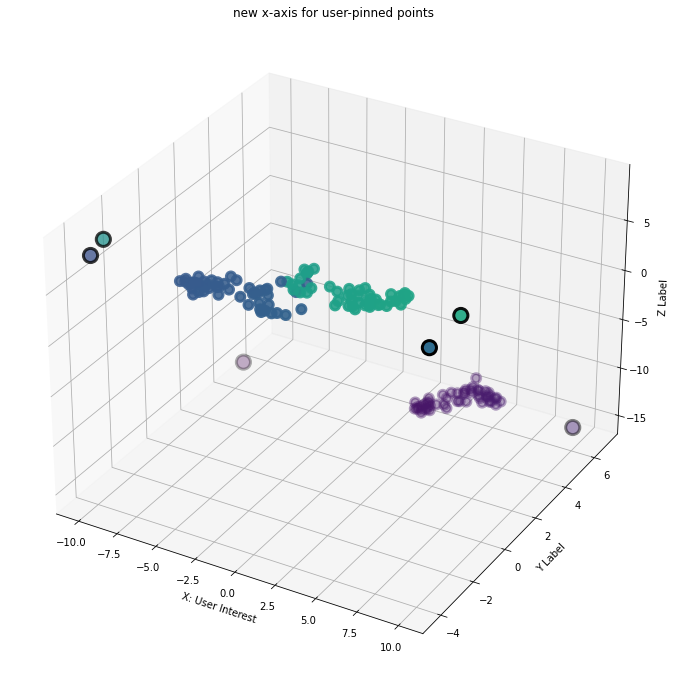

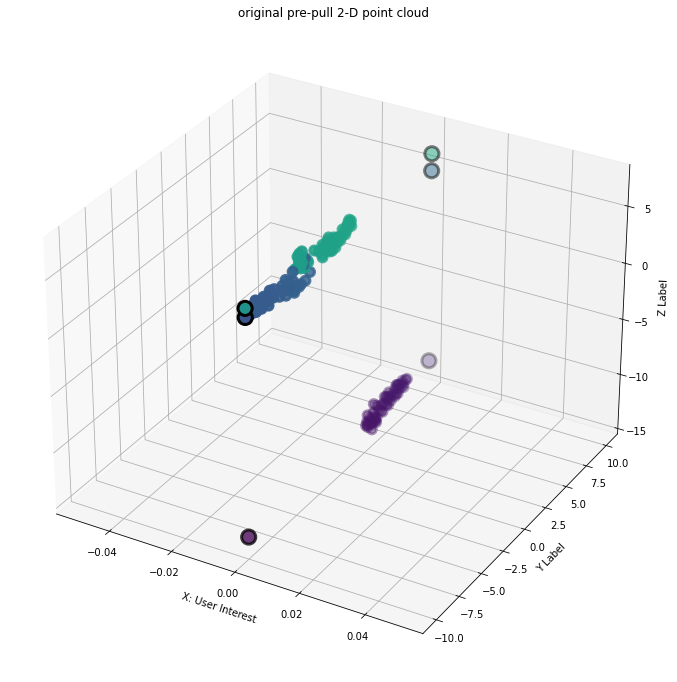

In [26]:
from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mpcolors
#fig, (ax,bx) = plt.subplots(nrows=1, ncols=2, figsize=(24, 12),
#    subplot_kw={'projection': '3d'})
fig = plt.figure(figsize=(12, 12))
# 3-D projection axes
ax = plt.axes(projection='3d')
# defined axes
x,y,z = (emb6[:,0], emb6[:,1], emb6[:,2])
#c = iris.data[:,0]
s = np.full((x.shape[0]), 80); s[good10] = 200; s[bad10] = 200
#s = 80
c = 0.25 * (iris.target + (x+10.)*0.02)
ec = mpl.cm.viridis(c)
ec[good10,:] = [0.,0.,0.,1.]
ec[bad10,:]  = [0.,0.,0.,1.]
ax.scatter(x,y,z,s=s, c=c,norm=mpl.colors.Normalize(0.0,1.0),
           edgecolor=ec, linewidth=3)
#plot
ax.set_title('new x-axis for user-pinned points')
ax.set_xlabel('X: User Interest')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()
#
# for comparison, let's look at the original 2-D UMAP in same coordinates
# (before pulling user points off x=0)
#
fig = plt.figure(figsize=(12,12))
x,y,z = (np.zeros_like(emb4[:,0]), emb4[:,0], emb4[:,1])
bx = plt.axes(projection='3d')
bx.scatter(x,y,z,s=s, c=c,norm=mpl.colors.Normalize(0.0,1.0),
           edgecolor=ec, linewidth=3)
#plot
bx.set_title('original pre-pull 2-D point cloud')
bx.set_xlabel('X: User Interest')
bx.set_ylabel('Y Label')
bx.set_zlabel('Z Label')
plt.show()
#

In [27]:
#  Next: How to "simply" project yz onto single axis (pca for yz)
yz = emb6[:,1:3]
print("yz",yz[10:15,:])
print("emb2",emb2[10:15,:])
from sklearn.decomposition import PCA
pca = PCA(n_components=1, whiten=True)
pca.fit(yz)
#Project the data in 2D
%time y_pca = pca.transform(yz)
print("y_pca",y_pca.shape,"\n",y_pca[10:15])
emb7 = np.zeros_like(emb2)
emb7[:,0] = emb6[:,0]
emb7[:,1] = y_pca[:,0]
print("emb7",emb7[10:15,:])

yz [[  6.234079  -14.137488 ]
 [  5.2457633 -14.527646 ]
 [  4.7545323 -14.451795 ]
 [  4.52476   -14.886934 ]
 [  6.0512066 -14.559438 ]]
emb2 [[  2.84058879 -12.97767897]
 [  4.97415208 -12.42027445]
 [  6.32363196 -12.8172435 ]
 [  6.47720251 -12.11776187]
 [  2.46912696 -13.00592535]]
CPU times: user 1.76 ms, sys: 0 ns, total: 1.76 ms
Wall time: 308 µs
y_pca (150, 1) 
 [[1.4028206]
 [1.4037768]
 [1.3819497]
 [1.4106461]
 [1.431912 ]]
emb7 [[  4.54696751   1.40282059]
 [  2.57466412   1.40377676]
 [  1.54088449   1.38194966]
 [-10.           1.41064608]
 [ 10.           1.43191195]]


In [28]:
source.data["x7"] = emb7[:,0]
source.data["y7"] = emb7[:,1]
source.data["user"] = iris.data[:,0] # first feature, sepal length, used for pins
tooltips[0] = ("(x,y)",  "(@x4,@y4)")
# gray boxes around good-bad (fake) drag'n'drop "category"
gb = np.vstack([emb7[good10,], emb7[bad10,]])
gbsource.data["x7"] = gb[:,0]
gbsource.data["y7"] = gb[:,1]

p7 = figure(title="Iris UMAP --> 3D --pca--> 2D",
            tooltips=tooltips)
#mycmap = linear_cmap(field_name='user', palette='Viridis256',
#                     low=min(iris.data[:,0]) ,high=max(iris.data[:,0]))
circles = p7.circle( source=source, x="x7", y="y7",
    size=8, fill_alpha=0.5,
    color={"field": "label", "transform": cmap},
    #color=mycmap, # {"field": "user", "transform": mycmap},
    legend_group="label"
)
hover = p7.select_one(HoverTool)
hover.renderers = [circles]
p7.square(source=gbsource, x="x7", y="y7",
          size=16, line_alpha=0.7, line_width=4, fill_alpha=0.0,
          color={"field": "label", "transform": cmap},
          legend_group="label"
)
p7.legend.location = 'center_center'

output_notebook()
show(p7)
output_file("iris4.html")
#show(gridplot([[p1,p2],[p4,p7]]))

iris_grid = gridplot([[p1,p2],[p4,p7]],
                     toolbar_location=None, #sizing_mode='stretch_width'
                    )
show(iris_grid)

# This did NOT work out... needed 'selenium' and then err about not running in chrome??
#iris_grid.width = 1024
#export_png(iris_grid, filename="/tmp/iris_grid.png")


Loading BokehJS ...

## Comments
- this demo is atypical

### test code (throwaway)

In [29]:
a=[1,2]
print(len(a))
b=np.array([[1.0, np.inf], [np.inf, np.inf]])
print(np.sum(a==np.inf), np.sum(b == np.inf))

2
0 3


In [30]:
import numba
import os
print(numba.typeof(None))
#
# uncomment next line to see:
#   The 'is not None' does not seem to get elided by numba
#os.environ.setdefault('NUMBA_DEBUG','1')
#
#@numba.njit((numba.types.int32,numba.types.optional(numba.types.int32)))
#
# this generates foo...Eii...   and foo...Eiv... funcs, but both seem complicated
#
# in some numba version this vomits about 'isinstance'
# detecting None seems somewhat fragile :(
#
#@numba.njit(["int32(int32,none)", "int32(int32,int32)"])
#def foo(a,b):
#    """ Return a+=b, if b is not None """
#    if isinstance(b,numba.types.NoneType):
#        a += b
#    return a

none


In [31]:
print("numba now seems to have trouble with isinstance")
if False:
    @numba.njit(["int32(int32,int32)", "int32(int32,bool)"])
    def foo2(a,b):
        """ Return a+=b, if b is not None """
        if not isinstance(b,bool):
            a += b
        return a

numba now seems to have trouble with isinstance


In [32]:
@numba.jit(fastmath=True, parallel=False)
def bar(a,bb):
    """ Return a+=b, if b is not None """
    if bb is not None:
        a += bb
    return a
#op0 = numba.njit( foo, fastmath=True, parallel=False) # NEED signature
#op0 = numba.njit( bar, signature=(numba.types.int32, numba.types.none), fastmath=True, parallel=False) # NEED signature
#op0.inspect_types(pretty=True)
print(bar(4,None))

4


In [33]:
print(bar(4,2))

6


In [34]:
idxs=[]
for i in range(5):
    idxs.append(i)
print(idxs)

[0, 1, 2, 3, 4]


In [37]:
if "reposition" in dir(umap.utils):
    # This init-helper was added to github kruus umap branch constraints
    #
    # Now try the 'reposition' on emb2 (6 picked points w/ best rotation)
    #help("umap.utils.reposition")
    #recall:
    #emb2 pinning init good10:
    #[[  6.47720251 -12.11776187]
    #[ -6.29080699   5.5100111 ]
    #[ -4.66873046   6.60774872]]
    #emb2 pinning init bad10:
    #[[  2.46912696 -13.00592535]
    #[ -1.300408     5.2159056 ]
    #[  3.31361343   7.7900176 ]]
    # emb3[good10,0] = -10
    # emb3[bad10,0]  = +10
    print(f"{good10=} x-coord --> -10.0")
    print(f"{bad10=} x-coord --> +10.0")
    up_pts = np.concatenate((good10,bad10))
    up_pos = emb2[up_pts,:]
    print(f"{up_pts=}")
    print(f"init {up_pos=}")
    up_pos[0:3,0] = -10.0
    up_pos[3:6,0] = +10.0
    print(f"final {up_pos=}")
    emb2a = emb2.copy()
    emb2a[good10,0] = -10.0
    emb2a[bad10,0] = +10.0
    #umapper = umapper50 # an initial one, n_neighbors=50
    umapper = embedder3 # a later one (equiv)
    emb2b = umap.utils.reposition(emb2, up_pts, up_pos, umapper, thresh=0.0, verbose=0, nnfactor=1.0 )
    emb2c = umap.utils.reposition(emb2, up_pts, up_pos, umapper, thresh=0.0, verbose=0, nnfactor=0.75 )
    emb2d = umap.utils.reposition(emb2, up_pts, up_pos, umapper, thresh=0.5, verbose=0, nnfactor=0.75 )
    print(f"init {emb2[up_pts,]=}")
    print(f"dragged {emb2a[up_pts,]=}")
    print(f"reposition [default] {emb2b[up_pts,]=}")
    title=("Iris "+method_names[method]+" drag'n'drop init, emb2")
    p2  = plot_emb(emb2, emb2_title)
    p2a = plot_emb(emb2a, "drag'n'drop user moved 6 points") # emb2, raw drag'n'drop
    p2b = plot_emb(emb2b, "drag'n'drop + reposition[default args] emb2b")
    p2c = plot_emb(emb2c, "drag'n'drop + reposition emb2c nnfactor=0.75")
    p2d = plot_emb(emb2d, "drag'n'drop + reposition emb2c nnfactor=0.75, thresh 0.5")
    repo_grid = gridplot([[p2,None],[p2a,p2b],[p2c,p2d]], toolbar_location=None)
    show(repo_grid)  # all plots identical ???
    #show(p2a)
    #show(p2b)
#

good10=array([ 13,  57, 106], dtype=int32) x-coord --> -10.0
bad10=array([ 14,  50, 131], dtype=int32) x-coord --> +10.0
up_pts=array([ 13,  57, 106,  14,  50, 131], dtype=int32)
init up_pos=array([[  6.47720251, -12.11776187],
       [ -6.29080699,   5.5100111 ],
       [ -4.66873046,   6.60774872],
       [  2.46912696, -13.00592535],
       [ -1.300408  ,   5.2159056 ],
       [  3.31361343,   7.7900176 ]])
final up_pos=array([[-10.        , -12.11776187],
       [-10.        ,   5.5100111 ],
       [-10.        ,   6.60774872],
       [ 10.        , -13.00592535],
       [ 10.        ,   5.2159056 ],
       [ 10.        ,   7.7900176 ]])
init emb2[up_pts,]=array([[  6.47720251, -12.11776187],
       [ -6.29080699,   5.5100111 ],
       [ -4.66873046,   6.60774872],
       [  2.46912696, -13.00592535],
       [ -1.300408  ,   5.2159056 ],
       [  3.31361343,   7.7900176 ]])
dragged emb2a[up_pts,]=array([[-10.        , -12.11776187],
       [-10.        ,   5.5100111 ],
       [-10

In [36]:
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#